In [21]:
# Imports
import pickle as pic
import numpy as np
import seaborn as sb
import nltk, string
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities
from gensim.models.coherencemodel import CoherenceModel
from collections import defaultdict
from nltk.corpus import stopwords
from sklearn.cross_validation import train_test_split
import time
import pyLDAvis.gensim
import pyLDAvis

%matplotlib inline

## Load Data and Models

In [22]:
# Load Data
all_data = pic.load(open("../Data/all_data.p"))

# Load models
ann_lda = pic.load(open("../Models/ann_lda_model.p"))
ref_lda = pic.load(open("../Models/ref_lda_model.p"))

# Load Corpuses
ann_corpus_bow = pic.load(open("../Models/ann_corpus_bow.p"))
ref_corpus_bow = pic.load(open("../Models/ref_corpus_bow.p"))
ann_corpus_lda = pic.load(open("../Models/ann_corpus_lda.p"))
ref_corpus_lda = pic.load(open("../Models/ref_corpus_lda.p"))

# Load Dictionaries
ann_dictionary = pic.load(open("../Models/ann_dictionary.p"))
ref_dictionary = pic.load(open("../Models/ref_dictionary.p"))

# Load Results
ann_results = pic.load(open("../Data/ann_lda_results.p"))
ref_results = pic.load(open("../Data/ref_lda_results.p"))

EOFError: 

## Evaluate Annotation LDA Models

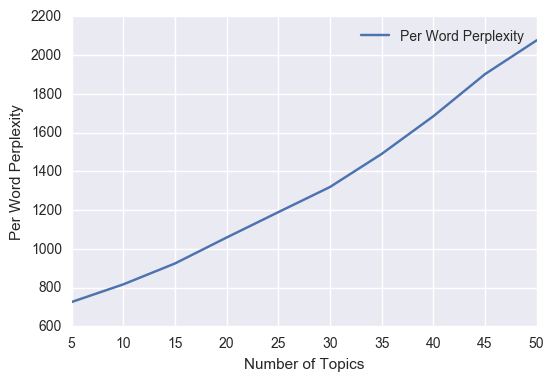

In [17]:
# Per Word Perplexity
create_chart(ann_results, "num_topics", "per_word_perplex", "Number of Topics",
             "Per Word Perplexity")

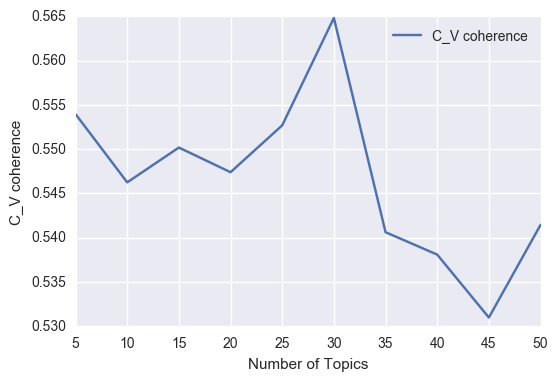

In [18]:
# C_V Coherence
create_chart(ann_results, "num_topics", "cv", "Number of Topics",
             "C_V coherence")

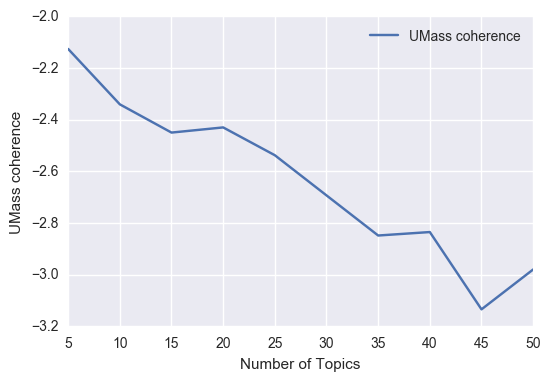

In [19]:
# UMASS Coherence
create_chart(ann_results, "num_topics", "umass", "Number of Topics",
             "UMass coherence")

In [20]:
# Prepare Visualization
ann_lda_vis = pyLDAvis.gensim.prepare(ann_lda, ann_corpus_bow, ann_dictionary)
pyLDAvis.display(ann_lda_vis)

## Evaluate Referent LDA Models

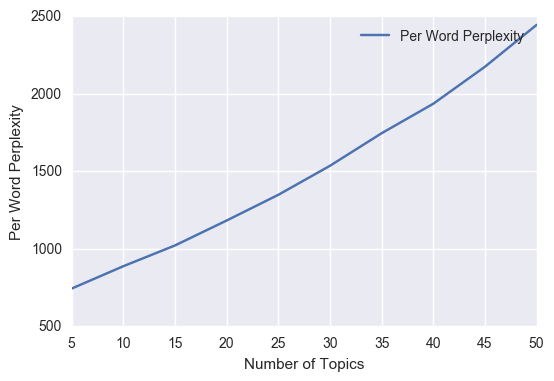

In [11]:
# Per Word Perplexity
create_chart(ref_results, "num_topics", "per_word_perplex", "Number of Topics", "Per Word Perplexity")

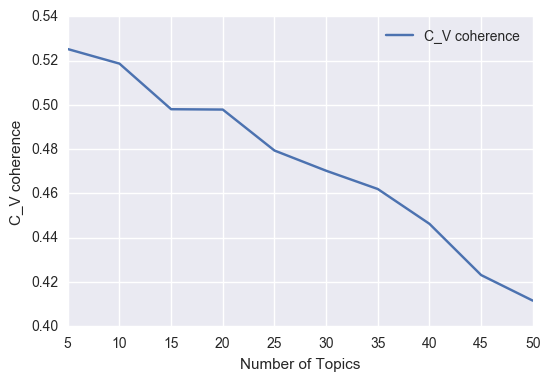

In [12]:
# C_V Coherence
create_chart(ref_results, "num_topics", "cv", "Number of Topics", "C_V coherence")

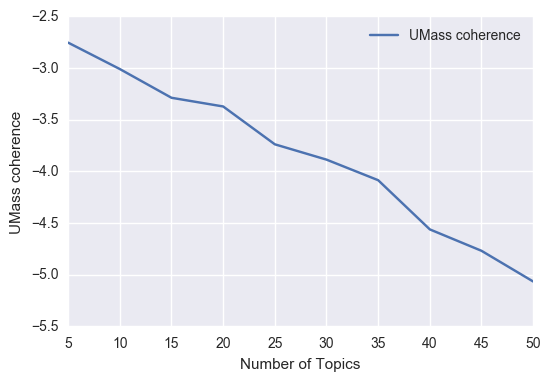

In [13]:
# UMASS Coherence
create_chart(ref_results, "num_topics", "umass", "Number of Topics", "UMass coherence")

In [15]:
# Prepare Visualization
ref_lda_vis = pyLDAvis.gensim.prepare(ref_lda, ref_corpus_bow, ref_dictionary)
pyLDAvis.display(ref_lda_vis)

In [ ]:
# Additional Visualizations

## Functions

In [4]:
def lda_evaluation(corpus, texts, dictionary, num_folds=3, topics=10, random_state=None):
    # Create train-test split
    train_corp, test_corp, train_texts, test_texts = train_test_split(corpus, texts, random_state=random_state)

    # Train LDA Model
    start = time.time()
    lda = models.LdaMulticore(train_corp, id2word=dictionary, 
                              num_topics=topics, iterations=50)
    train_time = time.time()
    print "Model trained in %s seconds." % (train_time - start)
    
    # Find perplexity on held out documents
    perplexity = lda.bound(test_corp)
    number_of_words = sum(len(doc) for doc in test_texts)
    per_word_perplex = np.exp2(-perplexity / number_of_words)
    perplexity_time = time.time()
    print "Perplexity found in %s seconds." % (perplexity_time - train_time)
    
    # Calculate coherence measures
    cm_cv = CoherenceModel(model=lda, texts=train_texts, 
                           dictionary=dictionary, coherence='c_v')
    cm_umass = CoherenceModel(model=lda, corpus=train_corp, 
                              dictionary=dictionary, coherence='u_mass')
    cv_coherence = cm_cv.get_coherence()
    umass_coherence = cm_umass.get_coherence()
    coherence_time = time.time()
    print "Coherence scores found in %s seconds." % (coherence_time - perplexity_time)
    
    # Return results
    result = [perplexity, per_word_perplex, cv_coherence, umass_coherence]
    return result

def test_topic_num(topic_num_list, corpus, texts, dictionary, random_state=None):
    # Create Reults DataFrame
    results = pd.DataFrame()
    
    # Evaluate topic model for each number of topics in list
    for num in topic_num_list:
        print "Number of topics being evaluated: %s" % num
        evaluation = lda_evaluation(corpus, texts, dictionary, 
                                    topics=num, random_state=random_state)
        print evaluation
        scores = pd.DataFrame(np.array([num] + evaluation, ndmin=2))
        results = results.append(scores)
    
    results.rename(columns={0: 'num_topics', 1: 'perplex', 2: 'per_word_perplex', 
                            3: 'cv', 4: 'umass'}, inplace=True)    
    return results

def create_chart(df, x, y, x_lab, y_lab):
    df.plot(x=x, y=y)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.legend([y_lab])
    